In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
# Load dataset
file_path = "/content/Super_Store_Data (Initial raw data).csv"
df = pd.read_csv(file_path)

In [ ]:
df.shape

(4824, 18)

In [ ]:
df["Segment"].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [ ]:
print(df.head())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688   12/6/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [ ]:
segment_summary = df.groupby("Segment").agg({
    "Sales": ["count", "mean", "sum"],
    "Category": pd.Series.nunique,
    "Sub-Category": pd.Series.nunique
}).reset_index()

segment_summary.columns = ["Segment", "Total_Orders", "Avg_Sales", "Total_Sales",
                           "Unique_Categories", "Unique_Subcategories"]


In [ ]:
print("\nSegment Level Summary:")
print(segment_summary)


Segment Level Summary:
       Segment  Total_Orders   Avg_Sales  Total_Sales  Unique_Categories  \
0     Consumer          2571  218.013305  560512.2059                  3   
1    Corporate          1360  231.166951  314387.0533                  3   
2  Home Office           892  258.068836  230197.4015                  3   

   Unique_Subcategories  
0                    17  
1                    17  
2                    17  


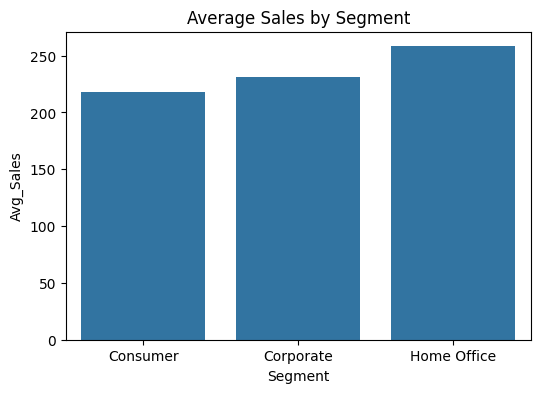

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x="Segment", y="Avg_Sales", data=segment_summary)
plt.title("Average Sales by Segment")
plt.show()


In [ ]:
customer_df = df.groupby(["Customer ID", "Segment"]).agg({
    "Sales": ["sum", "mean", "count"]
}).reset_index()

customer_df.columns = ["CustomerID", "Segment", "Total_Sales", "Avg_Sales", "Num_Orders"]

print("\nCustomer Level Data:")
print(customer_df.head())



Customer Level Data:
  CustomerID      Segment  Total_Sales   Avg_Sales  Num_Orders
0   AA-10315     Consumer     1127.988  225.597600           5
1   AA-10375     Consumer      764.698   84.966444           9
2   AA-10480     Consumer      632.532   90.361714           7
3   AA-10645     Consumer     2483.215  354.745000           7
4   AB-10060  Home Office     4821.552  482.155200          10


In [ ]:
X = customer_df[["Total_Sales", "Avg_Sales", "Num_Orders"]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

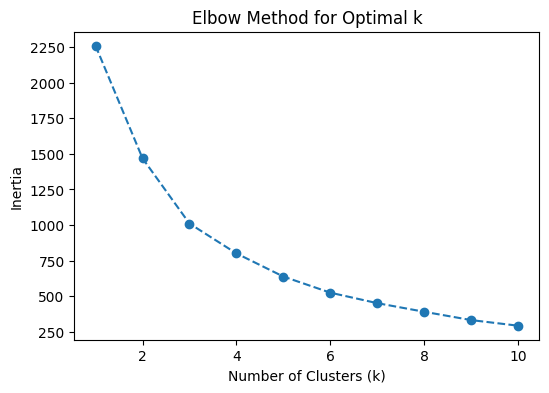

In [ ]:
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, "o--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
optimal_k = 4  # Assume elbow shows 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

print("\nClustered Customer Data:")
print(customer_df.head())


Clustered Customer Data:
  CustomerID      Segment  Total_Sales   Avg_Sales  Num_Orders  Cluster
0   AA-10315     Consumer     1127.988  225.597600           5        0
1   AA-10375     Consumer      764.698   84.966444           9        2
2   AA-10480     Consumer      632.532   90.361714           7        0
3   AA-10645     Consumer     2483.215  354.745000           7        2
4   AB-10060  Home Office     4821.552  482.155200          10        3


In [ ]:
cluster_summary = customer_df.groupby("Cluster").agg({
    "Total_Sales": "mean",
    "Avg_Sales": "mean",
    "Num_Orders": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Num_Customers"}).reset_index()

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   Cluster   Total_Sales    Avg_Sales  Num_Orders  Num_Customers
0        0    643.819468   159.606285    4.124224            483
1        1  15978.132333  2874.364287    5.666667              3
2        2   2196.751048   194.198236   11.420290            207
3        3   4857.833225   714.022982    7.500000             60


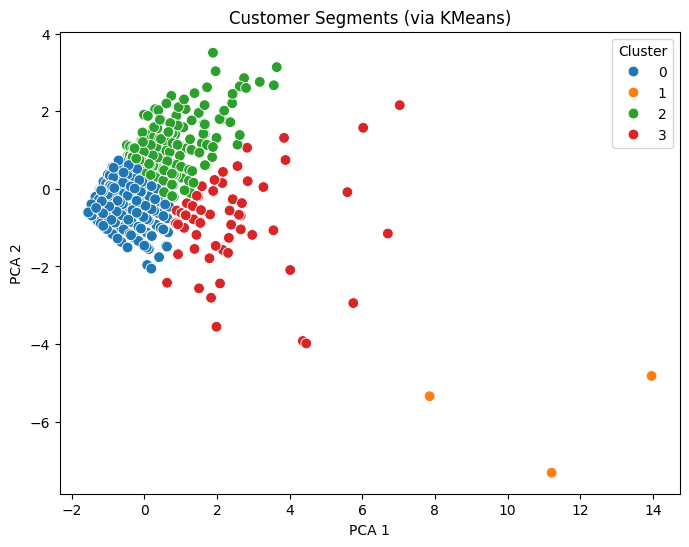

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=customer_df["Cluster"], palette="tab10", s=60)
plt.title("Customer Segments (via KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
def predict_customer_segment(total_sales, avg_sales, num_orders):
    # Create DataFrame with correct column names
    new_data = pd.DataFrame([[total_sales, avg_sales, num_orders]],
                            columns=["Total_Sales", "Avg_Sales", "Num_Orders"])

    # Scale the input
    new_data_scaled = scaler.transform(new_data)

    # Predict using trained KMeans
    cluster = kmeans.predict(new_data_scaled)[0]

    # Map to human-readable name
    cluster_labels = {
        0: "High-Value Customers",
        1: "Occasional Shoppers",
        2: "Frequent Low Spenders",
        3: "Moderate Buyers"
    }

    return cluster_labels[cluster]

In [ ]:
print("Predicted Customer Type:", predict_customer_segment(5000, 200, 30))

Predicted Customer Type: Frequent Low Spenders
